# Computer Vision Tutorial: Handwritten Digit Recognition

In this tutorial, we will build a computer vision program capable of recognizing images depicting digits between 0 and 9. Handwritten digit recognition is considered one of the simpler tasks in image recognition, although it was a challenging problem before the advent of modern machine learning techniques. By the end, you should have a model achieving an accuracy of approximately 99%, comparable to human performance.

This tutorial will consist in building several models:
 1. a simple neural network with one layer
 2. a neural network with several layers (the notorious multi layer perceptron)
 3. a convolutional neural network

You can load the solutions by uncommenting some sections the end, but try to solve the exercises first :).


## Install keras:
**As pytorch installation takes some time, start the installation before reading the exercises.**
To proceed, you need to have at least `keras` installed. You could download the dataset here http://yann.lecun.com/exdb/mnist/ , but this dataset is so standard that it is part of `keras`.
Installation commands may vary depending on your operating system (Linux/Mac/Windows) and whether you want to use a virtual environment.

With pip:

`pip install --upgrade keras`

`keras` is simply an API working on top of either `Tensorflow`, `Pytorch` of `JAX`, with a simpler syntax. In this TP we will use it with `Tensorflow` in the background, therefore you'll also need to install it:

`pip install tensorflow`

**Gpu acceleration:** The Keras library facilitates GPU usage for accelerated computation. However, installing CUDA drivers can be time-consuming. To optmize your time, I recommend focusing on the exercises first, which are not meant to be computationnaly extremely extensive, and deferring the driver installation until later.

In [1]:
!pip install --upgrade keras
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for keras from https://files.pythonhosted.org/packages/fc/a7/0d4490de967a67f68a538cc9cdb259bff971c4b5787f7765dc7c8f118f71/keras-2.15.0-py3-none-any.whl.metadata
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. Th

Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


# Problem decomposition
Given an image, we want to write a program that predicts the value depicted. The problem can be decomposed in several parts:
- transforming the image into a vector of numbers (embedding),
- apply the vector to a predictor function,
- evaluate the most likely digit from the output.

In our case, the embedding is quite simple as images are described as pixels, which are 2D vectors. Embedding in our case is quite straightforard, but can be tricky in other situations, such as the embedding of 3D objects such as molecules. The output of our function will be a vector of size 10 with each element being a probability between 0 and 1, representing how likely the element of the vector represent the digit on the picture. The hard part consist in finding a function that, given our embedded vector as input, returns an output giving the correct label most of the time.



![problem](single_digit_function.jpg)

# 1. Download and plot samples from the dataset


An crucial aspect of the work in machine learning, often overlooked, involves the creation of the dataset. Choosing relevant samples, ensuring they are correct, performing scaling operations and more.

As this step can be tedious and highly specific to each dataset, you will download an existing dataset and plot some samples. The dataset consist in 60000 handwritten digits that have been numerized in pictures of 28 pixels, more details in:
https://en.wikipedia.org/wiki/MNIST_database

You do not have to write any code in this section.

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

from keras.utils import plot_model

import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 18}
matplotlib.rc('font', **font)

# If we were to use JAX or pytorch, we could change using
### os.environ["KERAS_BACKEND"] = "jax" or "torch"

2024-03-25 13:26:22.919684: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-25 13:26:23.058549: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-25 13:26:23.928551: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu/openmpi/lib:/usr/local/cuda-11.4/lib64:
2024-03-25 13:26:23.928622: W te

In [3]:
# Download the dataset directly from keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# we normalize the data so that it is contained between 0 and 1, a common practice
x_train, x_test = x_train / 255.0, x_test / 255.0
# It is a good practice to shuffle dataset, however the function fit() does that automatically for us


# picking randomly an individual sample
idx_sample = np.random.randint(0, len(x_train))
image = x_train[idx_sample]
image = image.squeeze()
label = y_train[idx_sample]

# Plot the image
plt.imshow(image, cmap='gray')
plt.title(f'MNIST Digit: {label}')
plt.show()

# show the image in numbers
np.set_printoptions(precision=3)
print('shape of sample', image.shape)


shape of sample (28, 28)


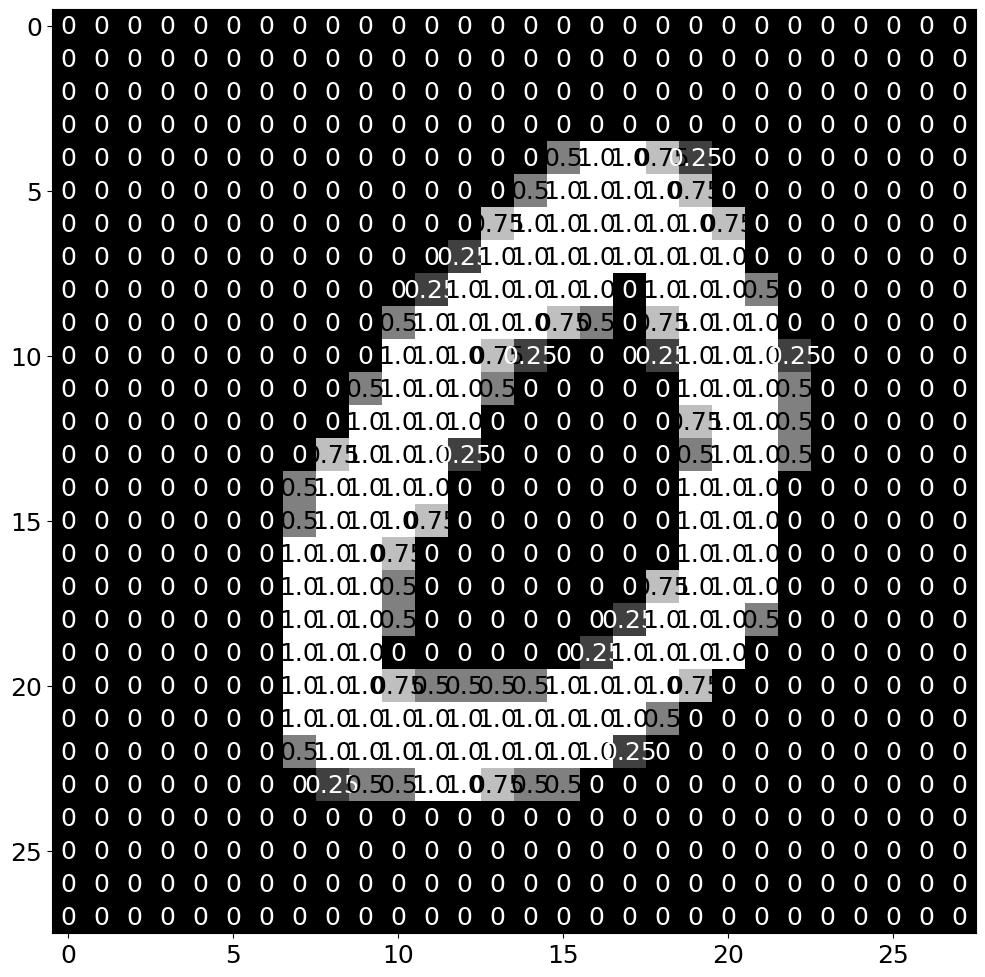

In [4]:
# small code samples taken from https://www.kaggle.com to vizualize values 

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(image, cmap='gray')
width, height = image.shape
thresh = image.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(image[x][y],2) if image[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if image[x][y]<thresh else 'black')




***
In this type of classifications problems, it is important to check if the different categories are roughly balanced. Ideally, no single category should dominate the dataset.
***

In [5]:
# acess the labels with train_dataset.targets
# Use numpy.bincount to count occurrences of each label
label_counts = np.bincount(y_train)

for label, count in enumerate(label_counts):
    print(f"Label {label}: Count {count}")

Label 0: Count 5923
Label 1: Count 6742
Label 2: Count 5958
Label 3: Count 6131
Label 4: Count 5842
Label 5: Count 5421
Label 6: Count 5918
Label 7: Count 6265
Label 8: Count 5851
Label 9: Count 5949


# 2. Define the Neural network architecture

Given a vector $\textbf{x}$ representing an image, our goal is to define a function $\hat y = f_\textbf{w}(\textbf{x})$ that outputs probabilities for each label. In our case, if $\textbf{x}$ corresponds to an image depicting the digit "2," a satisfactory prediction might be $\hat y = (0.1, 0.05, 0.9, 0.2, 0.1, 0.02, 0.1, 0.3, 0.4, 0.1)$, where the highest value in $\hat y$ indicates the most probable label for our image.
    
The objective during training is to determine the parameters $\textbf{w}$ such that the predicted labels are accurate for all images. This involves comparing the predicted vector $\hat y$ with the target vector $y_{\rm True} = (0, 0, 1, 0, 0, 0, 0, 0, 0, 0)$, where the "1" corresponds to the true label.

![multi layer perceptron](single_layer_MNIST.png)

We will construct a multi-layer perceptron (MLP) following the structure depicted in the figure above. Initially, we begin with a single layer. Our MLP is made of several artificial neurons, represented in blue, and connexions between them, represented as lines. Below we zoom on a single neuron. Each artificial perform a very basic operation, it multiplies the input $\textbf{x}$ by the weights $\textbf{w}$ and add a bias $b$. Then it applies a non-linear function $g$ and outputs $g(\textbf{w} \textbf{x} + b)$. Any non linear function $g$ could fit, but good choices could be the sigmoid or the Relu functions (note that in deep learning, "good" usually means approved empirically and the theoretical arguments driving choices are close to zero).

![multi layer perceptron](single_neuron_zoom.jpg)

<span style="font-size:16px;">

    
To build our network of articial neurons, we'll implement a model using **tensorflow.keras.models.Sequential**. This approach allows us to focus solely on defining the architecture without delving into the intricate details of individual neurons and their connexions.
    
We have to define the parameters of the architecture that depends on our problem at hand:

- What is the size of the input?
- What is the size of the output?
- Choose the number of hidden neurons, bigger means a more flexible model, smaller means faster training time
- Choose an activation function

The documentation of the pytorch is a good start:
https://keras.io/getting_started/intro_to_keras_for_engineers/
</span>


In [6]:
# Define the MLP model with ReLU and Dropout
def define_single_layer(input_size, output_size, hidden_neurons, activation_function):
    model = Sequential([
        Dense(hidden_neurons, activation=activation_function, input_shape=(input_size,)),
        Dense(output_size, activation='softmax')
    ])
    return model


# Define the number of neurons for the hidden layer, typically a power of 2
num_neurons = ...

# Create an instance of the custom neural network
pixel_number = ... # input size, hint: pictures have 28 pixels in each direction
output_size = ...  # output size
activation_function = ... # standard choices are relu, sigmoid, or tanh

# reshape the data to 1-dimensional vector
x_train, x_test = x_train.reshape(-1, pixel_number**2), x_test.reshape(-1, pixel_number**2)

# change target from number to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Instantiate the model
single_layer = define_single_layer(pixel_size, output_size, num_neurons, activation_function)

# Define a batch size
batch_size = ...


TypeError: unsupported operand type(s) for ** or pow(): 'ellipsis' and 'int'

<span style="font-size:16px;">
We need to defing an optimizer and a loss function. The purpose of the optimizer is to iteratively update the model parameters $\textbf{w}$ during training to minimize the loss function $L(y_{\rm True}, \hat y)$, guiding the model towards better performance. You also need to define the learning rate, which controls the size of the steps taken during optimization, and is a very important hyperparameter which strongly influence convergence. You should try several values.

</span>


In [7]:
#### uncomment to see a solution 
### %load solutions_keras/single_layer_solution.py
####

In [8]:
# %load solutions_keras/single_layer_solution.py
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


# Define the MLP model with ReLU and Dropout
def define_single_layer(input_size, output_size, hidden_neurons, activation_function):
    model = Sequential([
        Dense(hidden_neurons, activation=activation_function, input_shape=(input_size,)),
        Dense(output_size, activation='softmax')
    ])
    return model


# Define the number of neurons for the hidden layer, typically a power of 2
num_neurons = 64

# Create an instance of the custom neural network
pixel_number = 28 # pixel_size size,
output_size = 10  # output size
activation_function = 'relu' # standard choices are relu, sigmoid, or tanh

# reshape the data to 1-dimensional vector
x_train, x_test = x_train.reshape(-1, pixel_number**2), x_test.reshape(-1, pixel_number**2)

# Instantiate the model
single_layer = define_single_layer(pixel_number**2, output_size, num_neurons, activation_function)

# change target from number to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Define a batch size
batch_size = 32

2024-03-25 13:28:03.877195: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-25 13:28:03.884747: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-25 13:28:03.884925: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-25 13:28:03.886879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-25 13:28:03.887051: I tensorflow/compiler/xla/stream_executo

In [9]:
# check the model visually
single_layer.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


# 3. Do the training

We have defined an architecture and we have a function that depends on parameters. In the initial stage, we randomly selected the parameters, resulting in a function that is likely to perform poorly in recognizing digits—no better than random chance.

![first_evaluation](first_evaluation.jpg)

We need to improve the parameters of our function, a part that is called training in machine learning slang. The training consist in forward and backward passes, where the forward pass evaluate our function and the backward pass compute gradients of the function to update the parameters of our model. The objective is to iteratively reduce the loss.

![multi layer perceptron](training_nn_2.png)

Eventually, our function will be better at recognizing digits, reaching something like this:

![multi layer perceptron](final_evaluation.jpg)

To write the training function, you need to define:
- a loss function
- the step of the gradient descent (called the learning rate)
- the numerical scheme for the optimization
- the maximum number of epochs

To get help, I strongly recommend to get help from existing examples, such as https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

In [10]:
#### Define loss functions and optimizer

# specify loss function, cross entropy is the standard choice here
loss_function = ...

# specify optimizer and learning rate
# a strong learning rate means the weights are updated a lot at each iteration, 
# however, a too big learning rate will make you miss a narrow minimum
# If you see strong oscillations in error, learning rate is too big
# if nothing changes in a few epochs learning rate is too small
learning_rate = ...
optimizer_single_layer = ... # find optimizers in keras.optimizers., typically Adam or SGD

# The number of epochs is the number of times all the dataset is evaluated by the model
epochs = ...

In [11]:
#### uncomment to see a solution 
### %load solutions_keras/training.py
####

In [12]:
# %load solutions_keras/training.py
from tensorflow import keras

#### Define loss functions and optimizer

# specify loss function, cross entropy is the standard choice here
# be careful, targets can be one hot encoded or not, choose a loss in adequation.
loss_function = keras.losses.SparseCategoricalCrossentropy()

# specify optimizer and learning rate
# a strong learning rate means the weights are updated a lot at each iteration, 
# however, a too big learning rate will make you miss a narrow minimum
# If you see strong oscillations in error, learning rate is too big
# if nothing changes in a few epochs learning rate is too small
learning_rate = 0.01
optimizer_single_layer = keras.optimizers.Adam(learning_rate=learning_rate) # find optimizers in keras.optimizers., typically Adam or SGD

# The number of epochs is the number of times all the dataset is evaluated by the model
epochs = 10

In [13]:
# compile the model with your loss function, learning rate and optimizer
single_layer.compile(
    optimizer=optimizer_single_layer,
    loss=loss_function,
    metrics=['accuracy']
    )

In [14]:
single_layer.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


In [15]:
# perform the training, i.e. the forward and backward passes on all data
# Check the accuracy, with the single layer, you should at least get 80% after a single epoch.


history = single_layer.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)

Epoch 1/10


2024-03-25 13:28:15.358534: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1875/1875 [==============================] - 10s 4ms/step - loss: 0.2570 - accuracy: 0.9231 - val_loss: 0.1529 - val_accuracy: 0.9541
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1735 - accuracy: 0.9501 - val_loss: 0.1901 - val_accuracy: 0.9491
Epoch 3/10
1875/1875 [==============================] - 8s 5ms/step - loss: 0.1533 - accuracy: 0.9567 - val_loss: 0.1768 - val_accuracy: 0.9542
Epoch 4/10
1875/1875 [==============================] - 8s 5ms/step - loss: 0.1374 - accuracy: 0.9607 - val_loss: 0.1964 - val_accuracy: 0.9539
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1311 - accuracy: 0.9636 - val_loss: 0.1759 - val_accuracy: 0.9540
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1242 - accuracy: 0.9661 - val_loss: 0.1767 - val_accuracy: 0.9591
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1192 - accuracy: 0.9675 - val_loss: 0.1638 - val_accuracy: 0.9623
Ep

<span style="font-size:16px;">
Let's randomly select an image from the test set, one that our model hasn't encountered during training, and assess whether the label predicted by our latest model is accurate.
 </span>

1/1 [==============================] - 0s 117ms/step


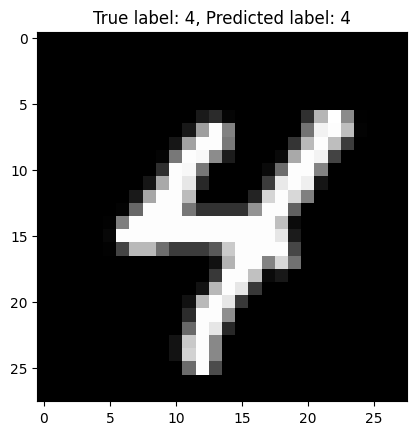

In [16]:
def plot_image_from_test(model, x_test, y_test):
    # Generate a random index
    random_index = np.random.randint(len(y_test))

    # Get the selected image and its true label
    selected_image = x_test[random_index]
    true_label = (y_test[random_index])

    # Reshape the selected image to match the model's input shape
    selected_image = selected_image.reshape(1, -1)

    # Use the trained model to predict the label of the selected image
    predicted_label = np.argmax(model.predict(selected_image))

    # Plot the selected image and the predicted label
    plt.imshow(selected_image.reshape(28, 28), cmap='gray')
    plt.title(f"True label: {true_label}, Predicted label: {predicted_label}")
    plt.show()

plot_image_from_test(single_layer, x_test, y_test)

### Question
<span style="font-size:16px;">
Intuitively the last model with the most epochs should perform better, as it did more steps to reduce the loss. Is this always the case? Is the accuracy the same on the training set and on the test set?
</span>

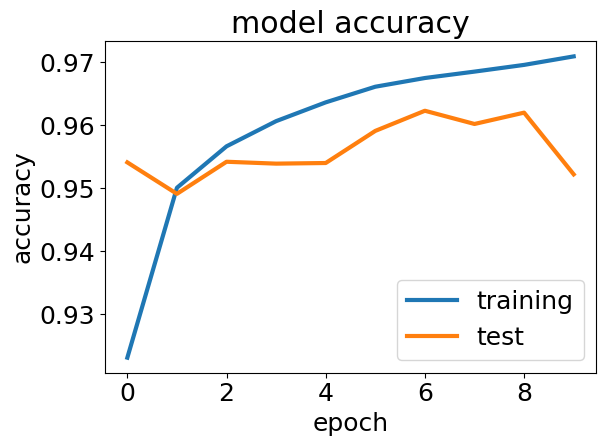

In [16]:
# plot the loss and the accuracy as a function of epochs

def plot_test_train_accuracy(history, model_name=''):
    plt.plot(history.history['accuracy'], label='training', lw=3)
    plt.plot(history.history['val_accuracy'], label='test', lw=3)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.tight_layout()
    
    plt.legend()
    plt.savefig(f'accuracy_{model_name}.pdf')
    

plot_test_train_accuracy(history, model_name='single_layer')

### Question:
<span style="font-size:16px;">

What happens with a too big learning rate? or a too small?
</span>


# 4. add more layers

![multi layer perceptron](several_layers_crop.jpg)

<span style="font-size:16px;">
    The model used in the previous section only used a single hidden layer. Even though a single layer can approximate any function (more details in https://en.wikipedia.org/wiki/Universal_approximation_theorem), it is usually beneficial to have a model with several layers. Empirically, a model with several layers will typically beat a model with a single layer, even if they have the same number of parameters. The training might be harder to perform if you have many layers. This will be considered as "deep" learning if you have at least 4 layers.

    
When building a model, testing several architectures is the most important (more important than finding the optimal hyperparameters), that is why you should:
- Write code that allows model changes easily
- Find a way to do bookepping of the several models
The bookepping consist in keeping a trace of all the models you trained,  there are good tools online like the open-source mlflow (https://mlflow.org/) or weight and biases (https://wandb.ai/site ).

To do this section, you must:
- write a model with several layers 
- Add some kind of regularization (for instance Dropout)
</span>

In [17]:
# We now define a model with several layers and dropout
def make_multi_layers(
    input_size,
    hidden_neurons,
    output_size,
    activation_function,
    dropout_prob=0.25
):
    
    model = keras.Sequential([
        ... # add keras.layers.Dense and keras.layers.Dropout as you wish
        keras.layers.Dense(output_size, activation='softmax') # final layer is similar
    ])
    return model

# choose a number of neurons for each layer. 
neurons = [..., ..., ...]

pixel_size = ...
output_size = ...
activation_function = ... # you can choose a different function for each layer, or the same

multi_layers = make_multi_layers(pixel_size, neurons, output_size,
                            activation_function, dropout_prob=0.2)

# Print the number of parameters in each layer
for name, param in multi_layers.named_parameters():
    print(f"Layer: {name}, Parameters: {param.numel()}")


SyntaxError: invalid syntax (1477005467.py, line 12)

In [18]:
####uncomment to see a solution 
### %load solutions_keras/several_layers.py
####

In [20]:
# %load solutions_keras/several_layers.py

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the MLP model with ReLU and Dropout
def make_multi_layers(
    input_size,
    output_size,
    hidden_neurons,
    activation_function,
    dropout_prob=0.25
    ):
    model = Sequential([
        Dense(hidden_neurons[0], activation=activation_function, input_shape=(input_size,)),
        Dropout(dropout_prob),
        Dense(hidden_neurons[1], activation=activation_function, input_shape=(input_size,)),
        Dropout(dropout_prob),
        Dense(hidden_neurons[2], activation=activation_function, input_shape=(input_size,)),
        Dropout(dropout_prob),
        Dense(output_size, activation='softmax')
    ])
    return model


# choose a number of neurons for each layer. 
neurons = [64, 128, 64]

pixel_number = 28
output_size = 10
activation_function = 'sigmoid' # let's have sigmoid for a change

# Instantiate the model
multi_layers = make_multi_layers(pixel_number**2, output_size, neurons, activation_function)

In [28]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# we normalize the data so that it is contained between 0 and 1, a common practice
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = x_train.reshape(-1, pixel_number**2), x_test.reshape(-1, pixel_number**2)

# change target from number to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [31]:
# specify loss function
loss_function_multi_layers = 'categorical_crossentropy'

# specify optimizer and learning rate
learning_rate = 0.1
optimizer_multi_layer = keras.optimizers.SGD(learning_rate=learning_rate)

In [32]:


# compile the model with your loss function, learning rate and optimizer
multi_layers.compile(
    optimizer=optimizer_multi_layer,
    loss=loss_function_multi_layers,
    metrics=['accuracy']
    )

# The training can be called as before with fit()
epochs = 5 # change if you want
history_multi_layer = multi_layers.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test)
)

Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.9115 - accuracy: 0.6937 - val_loss: 0.5797 - val_accuracy: 0.8344
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.6705 - accuracy: 0.7966 - val_loss: 0.4485 - val_accuracy: 0.8766
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.5591 - accuracy: 0.8367 - val_loss: 0.3890 - val_accuracy: 0.8922
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4899 - accuracy: 0.8565 - val_loss: 0.3338 - val_accuracy: 0.9065
Epoch 5/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4433 - accuracy: 0.8724 - val_loss: 0.3021 - val_accuracy: 0.9145


### Question (Hard):
<span style="font-size:16px;">
When plotting train and test loss, you may see that the train accuracy is smaller than the test one, which seems like a mistake. How can you explain this?
    </span>
    

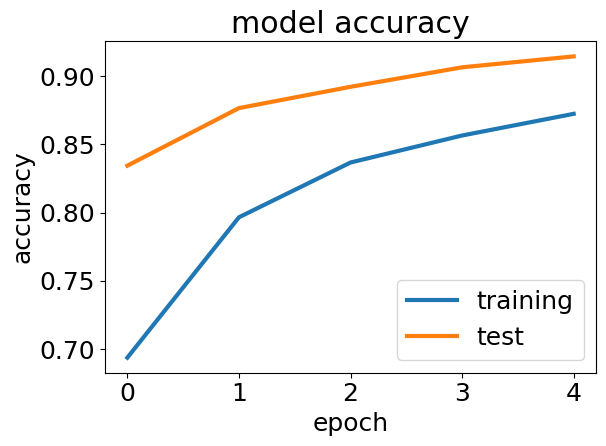

In [33]:
plot_test_train_accuracy(history_multi_layer, model_name='multi_layer')

# 5. Use a convolutionnal neural network

<span style="font-size:16px;">
    In this section, we introduce briefly the Convolutional Neural Network (CNN), which is a specialized type of neural network designed for image-related tasks. While the models we defined in the previous section are effective for general pattern recognition, CNNs are tailored specifically for visual data.

So far, our models have been very basic. We treated the input to our function as a flat sequence of pixels, neglecting any geometric information. By bruteforce, we searched for a function in a huge function space of 784 dimensions. This simplistic approach won't suffice for handling more intricate images, such as those found in ImageNet, that contains 256\*256 pixels and 3 colors. Additionnally we do not use translationnal invariance, implying that translations of two images depicting the same digit may produce different outputs.

To alleviate this issues, we will use convolutionnal neural network, which will greatly improve our performance.

In a nutshell, CNNs are build upon multi layer perceptrons like the one we wrote in previous sections, but introduce other types of layers, namely,
- **convolutional layers** 
The convolution operation is similar to a standard discrete convolution of two functions $f * g$, where $f$ is a learnnable kernelof a size we choose and $g$ the image. The kernel is used to scan input images and can extract local patterns such as edges.
- **pooling layers**, that reduce spatial dimensions while keeping features of images

 To learn more, Deep Learning from Goodfellow describe it precisely and gives good insight https://www.deeplearningbook.org/
 
 To visualize the effect of the different parameters, see the animations in https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
</span>

In [ ]:
# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# the force of conv network is that they spatial information. Therefore we do not flatten the image to 1D vector
# We reshape the images as the square original images
# Reshape the data to match the input shape of the Conv2D layer (samples, height, width, channels)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

In [ ]:
# Define the CNN model

def make_convolutionnal_nn(
    output_size,
    kernel_size,
    neurons,
    pool_size,
    activation_function,
    dropout_prob=0.2
):


    CNN_model = keras.models.Sequential([
        keras.layers.Input((28, 28, 1)),

        keras.layers.Conv2D(neurons, kernel_size, activation=activation_function),
        keras.layers.MaxPooling2D(pool_size),
        keras.layers.Dropout(dropout_prob),

        keras.layers.Conv2D(neurons*2, kernel_size, activation=activation_function),
        keras.layers.MaxPooling2D(pool_size),
        keras.layers.Dropout(dropout_prob),

        keras.layers.Flatten(),
        keras.layers.Dense(neurons*4, activation=activation_function),
        keras.layers.Dropout(dropout_prob),

        keras.layers.Dense(outpout_size, activation='softmax')
    ])
    return CNN_model

activation_function = ... # choose relu again
# choose the kernel size and the pooling size
kernel_size = (..., ...)
pool_size = (..., ...)

output_size = ...
neurons = ...

CNN_model = make_convolutionnal_nn(
    output_size,
    kernel_size,
    neurons,
    pool_size,
    activation_function,
    dropout_prob=0.2
)

CNN_model.summary()

In [ ]:
####uncomment to see a solution 
### %load solutions_keras/convolutionnal_neural_network.py
####

### Question
<span style="font-size:16px;">

If in the first convolutionnal layer you use no padding, a kernel of size 3x3, and fix out_channel to 20, what is the output size of the layer? 
</span>


In [ ]:
CNN_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# As usual, specify loss function
loss_function_conv = 'sparse_categorical_crossentropy'

# specify optimizer and learning rate
optimizer_conv = keras.optimizers.Adam()

In [ ]:
# Training again, you should easily get above 95 %, and you can reach 99%
CNN_model.compile(
    optimizer=optimizer_conv,
    loss=loss_function_conv,
    metrics=['accuracy']
    )

epochs = 10
history_CNN = CNN_model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=epochs,
    validation_data=(x_test, y_test)
)

In [ ]:
plot_test_train_accuracy(history_CNN)

## Some last remarks
If you made it here, you should have several models to recognize digits, including a CNN with likely 98\%+ accuracy. You can now use these codes as a starting point for your applications. However, keep in mind that they are relatively basic, and works mostly because the MNIST dataset is relatively simple and contains lots of samples. 

### Real applications
In practice, you may face several difficulties to have a working and useful model. For instance, because collecting data is expensive, it is likely that you only have access to a much smaller dataset. You may have access to only a hundred of samples. In that case, training a model from scratch is probably not a good approach. You should probably look if someone already solved a problem similar to yours. In that case, adapting its model will be a lot faster.

### more challenging datasets
 - CIFAR10: colored images with 10 labels
 - ImageNet (you may need more than your laptop to get a decent score).

